In [54]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
import scipy.interpolate as interpolate 
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

First look at the PCEB IGRNS data, starting with QS VIR. Cyndi has given me some stuff, but it looks as if the pipeline has improved since then.

In [2]:
os.listdir('.')

['SDCH_20190318_0023.spec_a0v.fits',
 'getdata_ss433_rebin.ipynb',
 'SDCK_20190318_0023.spec_a0v.fits',
 '.ipynb_checkpoints',
 'my_igrins.ipynb']

In [3]:
h_spec = 'SDCH_20190318_0023.spec_a0v.fits'
k_spec = 'SDCK_20190318_0023.spec_a0v.fits'
spectra = [h_spec, k_spec]

In [4]:
hdul = fits.open(h_spec)

In [5]:
hdul.info()

Filename: SDCH_20190318_0023.spec_a0v.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPEC_DIVIDE_A0V    1 PrimaryHDU     281   (2048, 28)   float64   
  1  WAVELENGTH    1 ImageHDU       280   (2048, 28)   float64   
  2  TGT_SPEC      1 ImageHDU       280   (2048, 28)   float32   
  3  A0V_SPEC      1 ImageHDU       280   (2048, 28)   float32   
  4  VEGA_SPEC     1 ImageHDU       280   (2048, 28)   float64   
  5  SPEC_DIVIDE_CONT    1 ImageHDU       280   (2048, 28)   float64   


In [10]:
hw, hf = hdul[1].data, hdul[0].data

(0, 200000.0)

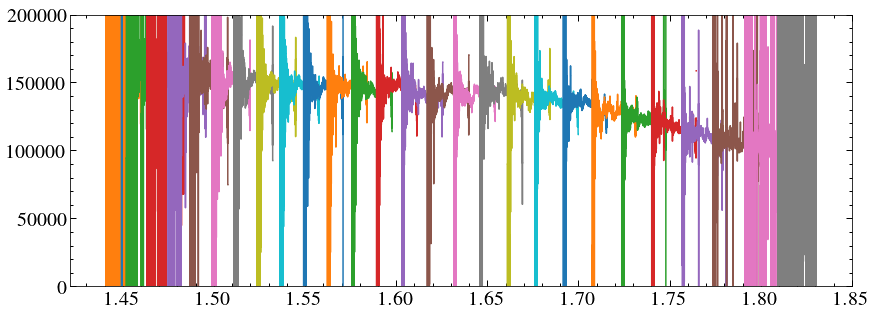

In [19]:
for wi, fi in zip(hw[::-1], hf[::-1]): #orders are in reverse
    plt.step(wi, fi)
plt.ylim(0, 0.2e6)

Ok... need to splice orders together, doing something about the edges. Is there an error file?

In [20]:
hvar = fits.open('SDCH_20190318_0023.variance.fits')

In [21]:
hvar.info()

Filename: SDCH_20190318_0023.variance.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     277   (2048, 28)   float32   


In [28]:
he1 = hvar[0].data

(0, 20000.0)

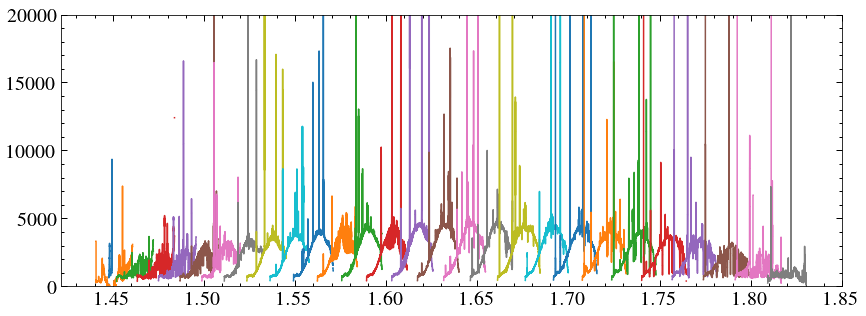

In [29]:
for wi, ei in zip(hw[::-1], he1[::-1]): #orders are in reverse
    plt.step(wi, ei)
plt.ylim(0, 0.2e5)

So it's not corrected?

In [39]:
he = he1
for i in range(len(he)):
    he[i] = ((he1[i]**0.5)/hdul[2].data[i])*hf[i]

/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 200000.0)

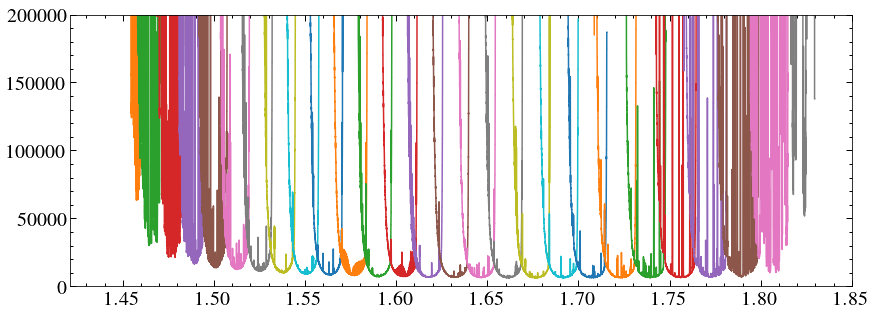

In [40]:
for wi, ei in zip(hw[::-1], he[::-1]): #orders are in reverse
    plt.step(wi, ei)
plt.ylim(0, 0.2e6)

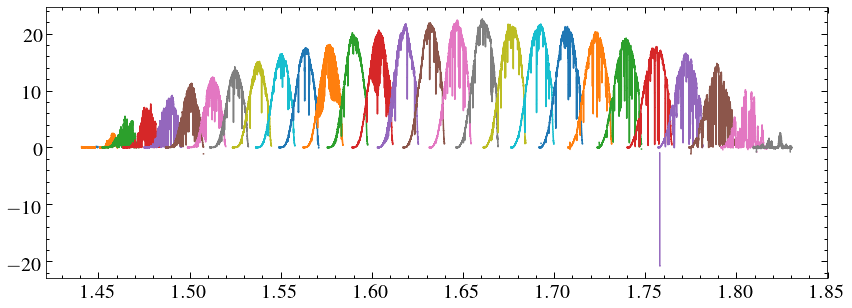

In [46]:
for wi, fi, ei in zip(hw[::-1], hf[::-1], he[::-1]):
    plt.step(wi, fi/ei)

Looks about what we were after?

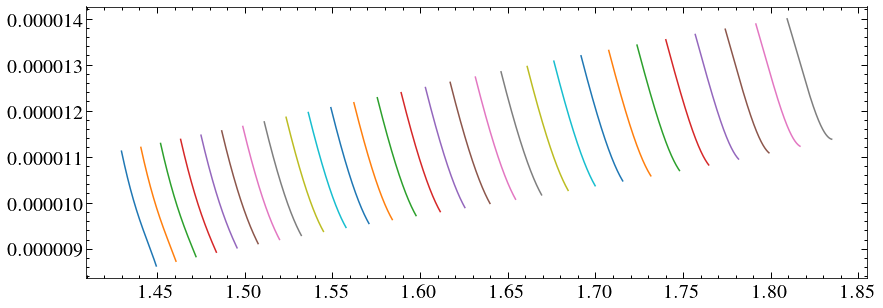

In [47]:
for wi in hw[::-1]:
    plt.plot(wi[:-1], np.diff(wi))

Hmm, could dump this into my stis code? Need to take out the DQ bits, easier to copy it in here.

In [58]:
def echelle_coadd(wavelength, flux, err):
    """
    combines echelle orders into one spectrum, stiching them together at the overlap 
    """
    
    #new arrays to put the output in
    w_full = np.array([], dtype=float)
    f_full = np.array([], dtype=float)
    e_full = np.array([], dtype=float)   

    shape = np.shape(flux)
    order = 0
    while order < (shape[0]):
        
        #first add the part that does not overlap ajacent orders to the final spectrum
        if order == 0: #first and last orders do not overlap at both ends
            overmask = (wavelength[order] > wavelength[order + 1][-1])
        elif order == shape[0]-1:
            overmask = (wavelength[order] < wavelength[order - 1][1])
        else:
            overmask = (wavelength[order] > wavelength[order + 1][-1]) & (wavelength[order] < wavelength[order - 1][1])
        w_full = np.concatenate((w_full, wavelength[order][overmask]))
        f_full = np.concatenate((f_full, flux[order][overmask]))
        e_full = np.concatenate((e_full, err[order][overmask]))
  
        if order != shape[0]-1:
            
            #interpolate each order onto the one beneath it, with larger wavelength bins. Code adapted from stisblazefix
            f = interpolate.interp1d(wavelength[order + 1], flux[order + 1], fill_value='extrapolate')
            g = interpolate.interp1d(wavelength[order + 1], err[order + 1], fill_value='extrapolate')
            overlap = np.where(wavelength[order] <= wavelength[order + 1][-1])
            f0 = flux[order][overlap]
            f1 = f(wavelength[order][overlap])
            g0 = err[order][overlap]
            g1 = g(wavelength[order][overlap])
       
             
            #combine flux and error at overlap and add to final spectrum
            w_av = wavelength[order][overlap]
            f_av, e_av = spectra_adder(np.array([f0,f1]),np.array([g0,g1]))
            w_full = np.concatenate((w_full, w_av))
            f_full = np.concatenate((f_full, f_av))
            e_full = np.concatenate((e_full, e_av))
        order += 1
    
    #stis orders are saved in reverse order, so combined spectra are sorted by the wavelength array
    arr1inds = w_full.argsort()
    sorted_w = w_full[arr1inds]
    sorted_f = f_full[arr1inds]
    sorted_e = e_full[arr1inds]
 
    
    return sorted_w, sorted_f, sorted_e

In [52]:
def spectra_adder(fluxes, errors):
    """
    combines the flux at each overlap
    """
    weight_f = np.average(fluxes, axis =0, weights=(1/errors**2))
    weight_e = np.average((weight_f - fluxes)**2, axis=0, weights = (1/errors**2))**0.5
    return weight_f, weight_e

In [59]:
ahw, ahf, ahe = echelle_coadd(hw, hf, he)

(0, 200000.0)

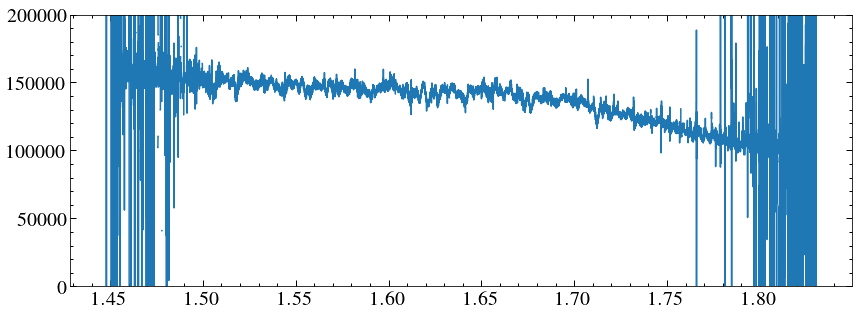

In [61]:
plt.step(ahw, ahf)
plt.ylim(0, 0.2e6)

Huh it worked?

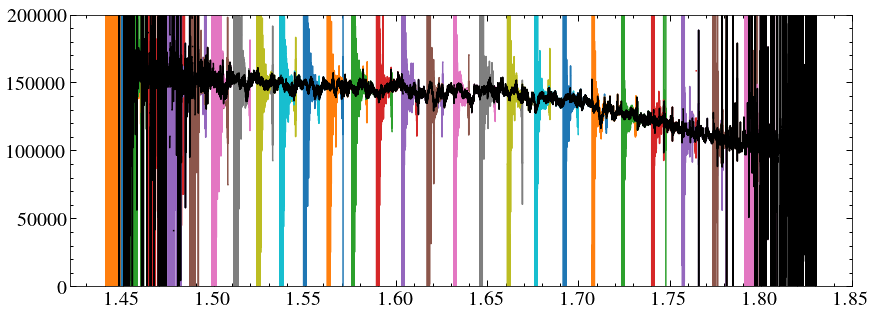

In [66]:
for wi, fi in zip(hw[::-1], hf[::-1]): #orders are in reverse
    plt.step(wi, fi)
plt.ylim(0, 0.2e6)
plt.step(ahw, ahf, 'k')

(1.675, 1.68)

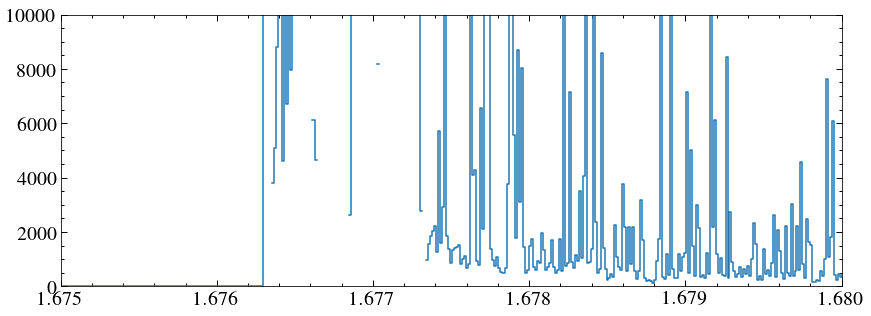

In [87]:
#plt.step(ahw, ahf)
#plt.step(ahw, ahe)
plt.ylim(0,10000)
plt.step(ahw, ahf/ahe)
plt.xlim(1.675, 1.68)


Why are there holes in my spectrum python? - nans? Ok errorbars didn't work so well, we can work on that.

(0, 50)

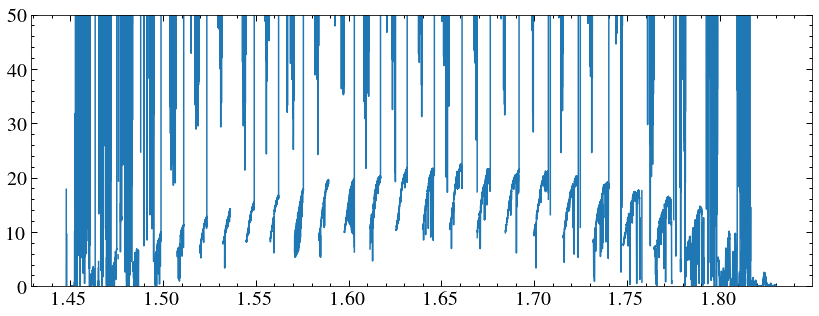

(1.49, 1.79)

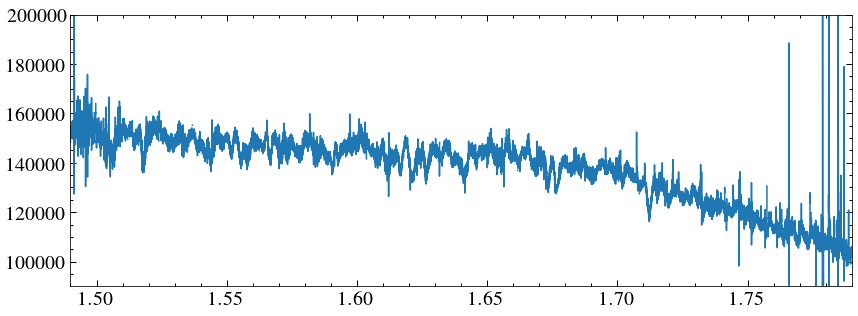

In [92]:
plt.step(ahw, ahf)
plt.ylim(0.9e5, 2e5)
plt.xlim(1.49, 1.79)

(1.6, 1.65)

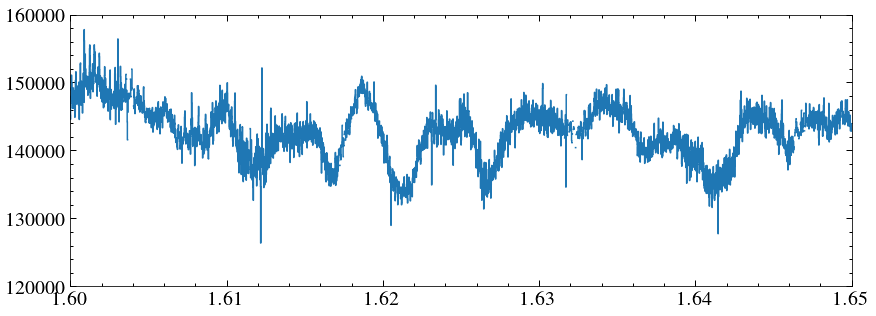

In [95]:
plt.step(ahw, ahf)
plt.ylim(1.2e5, 1.6e5)
plt.xlim(1.6, 1.65)

Rince and repeat for the k band I guess.

In [96]:
hdul.close()


In [97]:
kw, kf = fits.getdata(k_spec, 1), fits.getdata(k_spec, 0)

(0, 200000.0)

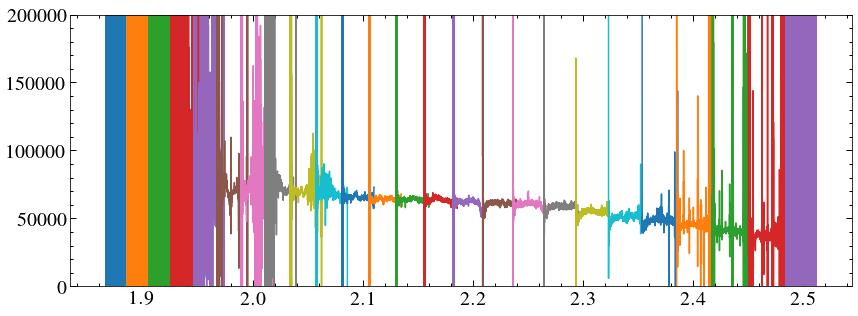

In [108]:
for wi, fi in zip(kw[::-1], kf[::-1]): #orders are in reverse
    plt.step(wi, fi)
plt.ylim(0, 0.2e6)

In [99]:
ke1 = fits.getdata('SDCK_20190318_0023.variance.fits', 0)

In [102]:
ke = ke1
for i in range(len(ke)):
    ke[i] = ((ke1[i]**0.5)/fits.getdata(k_spec,2)[i])*kf[i]

In [103]:
akw, akf, ake = echelle_coadd(kw, kf, ke)

(0, 200000.0)

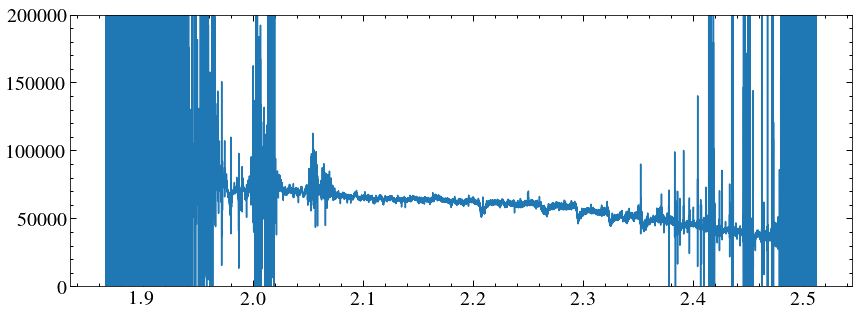

In [105]:
plt.step(akw, akf)
plt.ylim(0, 0.2e6)

A lot more messy but still a lot of lines. Tellurics at the edges?

(20000.0, 100000.0)

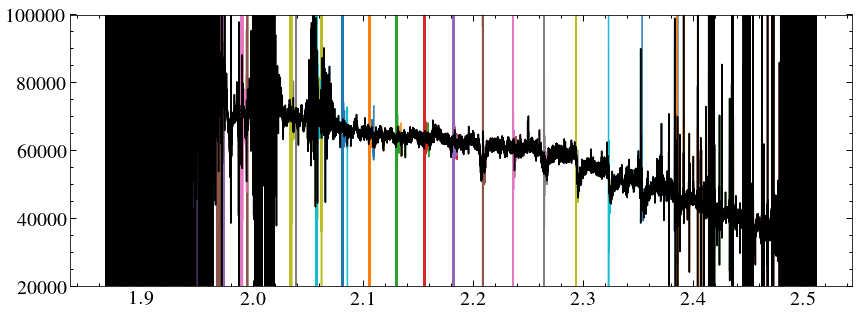

In [107]:
for wi, fi in zip(kw[::-1], kf[::-1]): #orders are in reverse
    plt.step(wi, fi)
plt.step(akw, akf, 'k')
plt.ylim(0.2e5, 1e5)

Hmm, looks like less improvement - maybe there is less overlap? What's the relative flux like?

(20000.0, 200000.0)

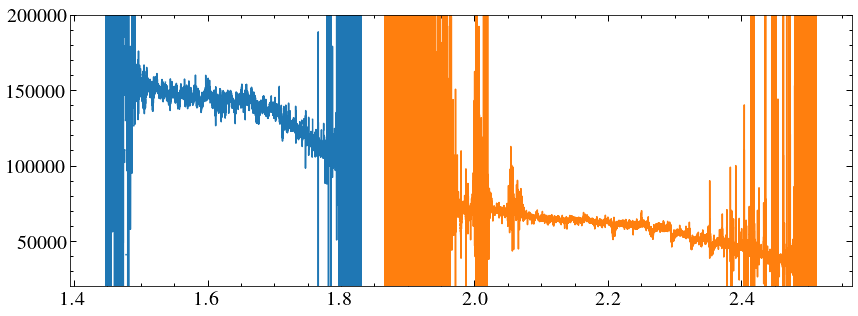

In [111]:
plt.step(ahw, ahf)
plt.step(akw, akf)
plt.ylim(0.2e5, 2e5)

Not great, although I could beleve it?